## Mackey-Glass equation - 1D example

In [79]:
using CairoMakie
using LinearAlgebra
include("mackeyglassfunc.jl") #system of Mackey-Glass equation
include("mackeytau.jl") #Delay forumla for Mackey-Glass equation
include("f_deriv.jl") #used to find state and/or parameter derivatives
include("jacobian_new.jl") #Jacobian function
include("newton_new.jl") #Newton function
include("F_eq.jl") #Initialisates a function to find equilibria 
include("track_curve_new.jl") #Tracking curve function (used for continuation and equilibria branches)
include("stab_func.jl") #finds stability and eigenvalues (and eigenvector and ω is interested in Hopf bifurcation)

stab_func (generic function with 1 method)

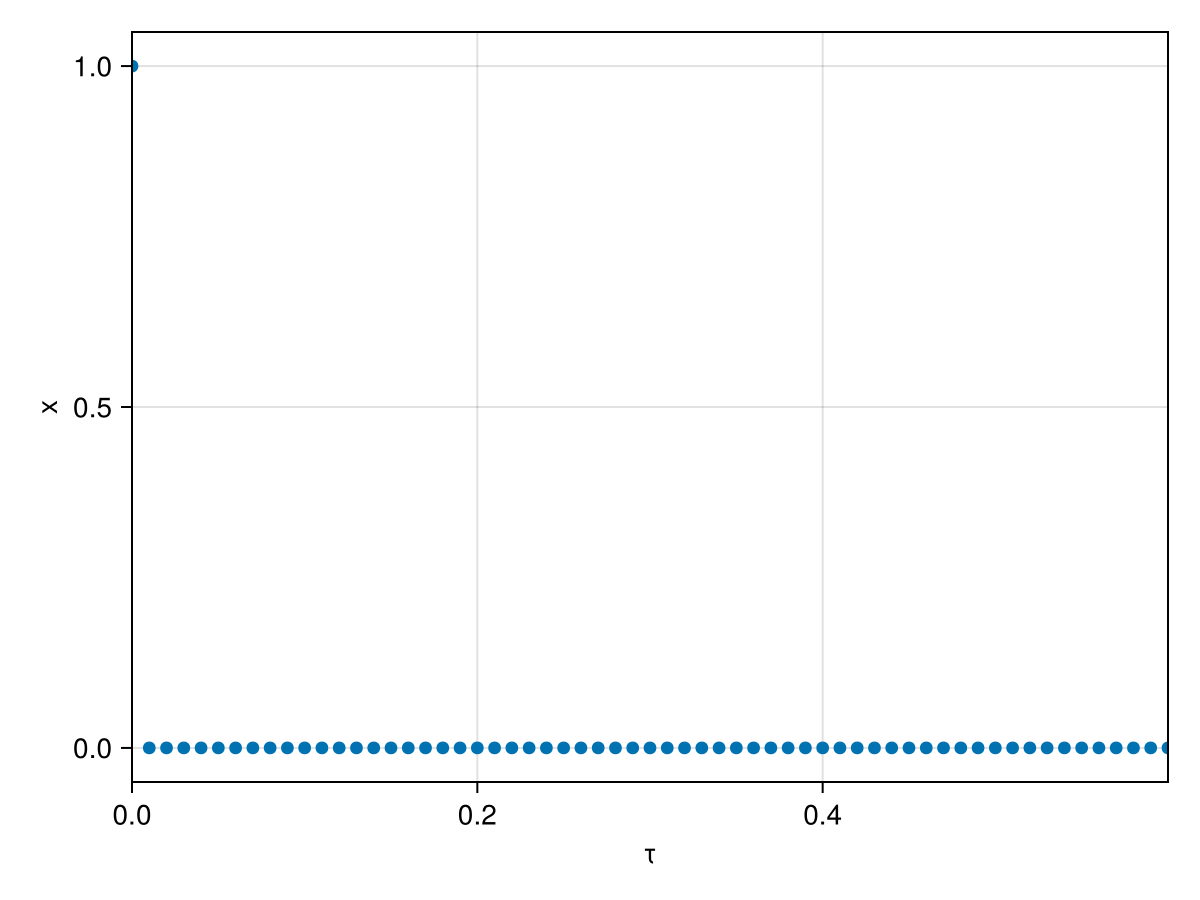

In [155]:
gamma=1.0
#initial states for following parameters (obtained from DDE-Biftool example)
beta=2
n=10 #n=3 gives γ/β >=1-2/n so all of x should be stable (By Gupta source)
tau=0
x0=((beta-gamma)/(gamma))^(1/n) #obtained from DDE-Biftool demo
nd=1 #one delay

y01,feq=F_eq(mackeyglassfunc, x0, [beta,gamma,n,tau],nd, par_indx=4)#par_indx=2)
#y01,feq=F_eq(mackeyglassfunc, x0, [gamma,beta,n,tau],nd, par_indx=4)#par_indx=2)

#y01,feq=F_eq(mackeyglassfunc,[0.0], [beta,gamma,n,tau],nd, par_indx=4)#par_indx=2)

ylist1,ytan1=track_curve_new(feq,y01,[0.0,1],stepsize=0.01,nmax=100) #i think it should output 1's for x value
#ylist1,ytan1=track_curve_new(feq,y01,[0.0,1],stepsize=0.1,nmax=10) #i think it should output 1's for x value

#ylist1,ytan1=track_curve_new(feq,y01,[0.0,1],nmax=150) #i think it should output 1's for x value
#ylist2,ytan2=track_curve_new(feq,y01,[0,0],nmax=150) #i think it should output 1's for x value


fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="τ",ylabel="x")
scatter!(ax1,[u[2] for u in ylist1],[u[1] for u in ylist1])
#scatter!(ax1,[u[2] for u in ylist2],[u[1] for u in ylist2])

#xlims!(ax1,[0.0,5])
xlims!(ax1,[0,0.6])
fig1

In [156]:
y01

2-element Vector{Float64}:
 1.0
 0.0

In [168]:
feq(y01)

1-element Vector{Float64}:
 3.0

# Stability

In [169]:
#stability of initial point
stab_func(mackeyglassfunc,mackeytau, [x0], [0.4],[gamma,beta,n,tau], [4], nd, doprint=1)

(0, ComplexF64[-486.5289656085163 - 7.397079734819737im, -486.5289656085163 + 7.397079734819737im, -485.6068317098502 - 22.162545907171324im, -485.6068317098502 + 22.162545907171324im, -483.7661269459444 - 36.84204304292214im, -483.7661269459444 + 36.84204304292214im, -481.01396356336613 - 51.37862753860058im, -481.01396356336613 + 51.37862753860058im, -477.3609754340446 - 65.71590791821099im, -477.3609754340446 + 65.71590791821099im  …  -19.30717300577917 + 70.36177308375669im, -14.804057989530518 - 55.90579571845669im, -14.804057989530518 + 55.90579571845669im, -11.026976106629544 - 41.176222690228144im, -11.026976106629544 + 41.176222690228144im, -7.821488937133693 - 26.200945328102293im, -7.821488937133693 + 26.200945328102293im, -4.540610868740805 - 11.018123409085364im, -4.540610868740805 + 11.018123409085364im, 2.9581047868903095e-13 + 0.0im], ComplexF64[-0.0013307813247535217 + 2.0316423304953698e-5im -0.0013307813247535217 - 2.0316423304953698e-5im … 0.0074472078967822005 + 0.

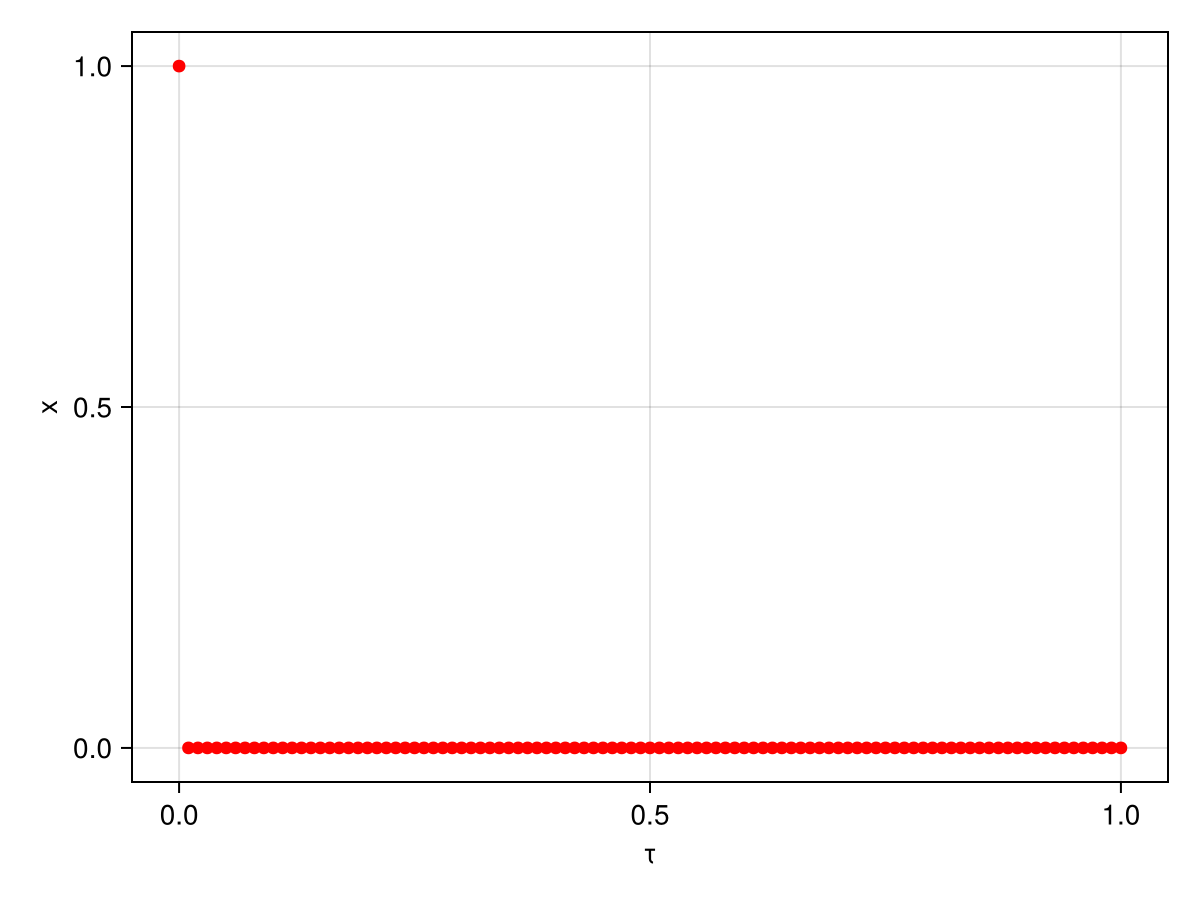

In [170]:
xmat1=hcat([u[1] for u in ylist1])
xlist1=[xmat1[i,:] for i in 1:size(xmat1,1)]

plist1=[u[2] for u in ylist1]

m=100 #number of discretised steps
n=1 #number of states 
neq=length(plist1) #number of equilibrium points we're finding the stability of
stab=fill(NaN,neq)
#eigvals1=[fill(0.0+0.0*im,n*(1+nd*m)) for _ in 1:neq]

#for i in 1:neq
for i in 2:neq
    #stab[i],eigvals1[i],=stab_func(mackeyglassfunc,mackeytau,xlist1[i],[plist1[i]],[beta,gamma,n,tau],[4],nd,doprint=1,m=m)
    stab[i]=stab_func(mackeyglassfunc,mackeytau,xlist1[i],[plist1[i]],[beta, gamma,n,tau],[4],nd,doprint=0,m=m)[1]
end
#stab
stab[1]=0.0
stable=(stab.==1.0)
unstable=(stab.==0.0)

fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="τ",ylabel="x")
scatter!(ax2,plist1[stable],[u[1] for u in xlist1[stable]], color="green")
scatter!(ax2,plist1[unstable],[u[1] for u in xlist1[unstable]], color="red")
#xlims!(ax2,[0.0,0.6])
#xlims!(ax2,[0,0.6])
fig2


In [172]:
#hopf_indx=findlast(isequal(0.0), stab)
hopf_indx=findfirst(isequal(1.0), stab[3:end])
p_hopf_est=plist1[hopf_indx+2]

MethodError: MethodError: no method matching +(::Nothing, ::Int64)
The function `+` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base operators.jl:596
  +(!Matched::Complex{Bool}, ::Real)
   @ Base complex.jl:323
  +(!Matched::ChainRulesCore.NoTangent, ::Any)
   @ ChainRulesCore C:\Users\ems237\.julia\packages\ChainRulesCore\XAgYn\src\tangent_arithmetic.jl:59
  ...


In [173]:
include("create_hopffunc.jl")
yh01,fhopf=create_hopffunc(mackeyglassfunc,mackeytau,[gamma,beta,n,tau],xlist1[hopf_indx],[plist1[hopf_indx]],[4],nd)
#yh01,fhopf=create_hopffunc(mackeyglassfunc,mackeytau,[gamma,beta,n,tau],xlist1[hopf_indx],[0.55],[4],nd)
println("The initial guess for Hopf info: $yh01")
yh1,conv1,=newton_new(fhopf,yh01)
println("The true information for the Hopf bifurcation: $yh1")
println("converged?: $conv1")
a_hopf=yh1[end]
om_hopf=yh1[end-1]
x_hopf=yh1[1]
println("The a value for hopf bifurcation: $a_hopf")
println("The ω value for hopf bifurcation: $om_hopf")

ArgumentError: ArgumentError: invalid index: nothing of type Nothing

In [174]:
#gamma=1.0
#initial states for following parameters (obtained from DDE-Biftool example)
#beta=2
#n=5
#tau=2
#x0=(beta-1)^(1/n) #obtained from DDE-Biftool demo
#nd=1 #one delay

#y01,feq=F_eq(mackeyglassfunc, x0, [gamma,beta,n,tau],nd, par_indx=4)#par_indx=2)
#y01,feq=F_eq(mackeyglassfunc,[0.0], [gamma,beta,n,tau],nd, par_indx=3)#par_indx=2)

#ylist1,ytan1=track_curve_new(feq,y01,[0.0,1],stepsize=0.01,nmax=1000) #i think it should output 1's for x value
#ylist1,ytan1=track_curve_new(feq,y01,[1.0,1],stepsize=0.01,nmax=1000) #i think it should output 1's for x value

#ylist1,ytan1=track_curve_new(feq,y01,[0.0,1],stepsize=0.1,nmax=10) #i think it should output 1's for x value

#ylist1,ytan1=track_curve_new(feq,y01,[0.0,1],nmax=150) #i think it should output 1's for x value
#ylist2,ytan2=track_curve_new(feq,y01,[0,0],nmax=150) #i think it should output 1's for x value


#fig1=Figure()
#ax1=Axis(fig1[1,1],xlabel="n",ylabel="x")
#scatter!(ax1,[u[2] for u in ylist1],[u[1] for u in ylist1])
#scatter!(ax1,[u[2] for u in ylist2],[u[1] for u in ylist2])

#xlims!(ax1,[0.0,5])
#fig1